### Conclusiones Finales

- **Análisis Predictivo**: El modelo de red neuronal puede automatizar el proceso de calificación a partir de texto no estructurado, facilitando el monitoreo del sentimiento de los clientes a través de diversas plataformas.

- **Análisis de Sentimiento y Subjetividad**: Permite identificar el nivel general de satisfacción de los clientes y distinguir entre comentarios objetivos y opiniones subjetivas.

- **Modelado de Temas y Análisis Basado en Aspectos**: Brinda información detallada sobre áreas específicas de interés o preocupación, ayudando a la aerolínea a enfocarse en aspectos críticos a mejorar.

- **Resúmenes de Reseñas**: Ofrece una representación concisa de los comentarios de los clientes, útil para que los responsables de la toma de decisiones obtengan una visión rápida sin tener que profundizar en cada reseña individual.

### Propuesta de Valor para Flybondi

- **Mejora en la Satisfacción del Cliente**: Al comprender los sentimientos de los clientes y los aspectos que consideran importantes, Flybondi puede tomar decisiones basadas en datos para mejorar la experiencia del cliente.

- **Gestión de la Reputación**: El monitoreo del sentimiento en distintas plataformas ayuda a gestionar de manera proactiva la imagen pública de la aerolínea.

- **Planificación Estratégica**: Los conocimientos obtenidos del modelado de temas y el análisis basado en aspectos pueden orientar las estrategias de marketing y las mejoras en los servicios.

- **Asignación de Recursos**: Enfocarse en las áreas que impactan significativamente en la satisfacción del cliente permite optimizar la utilización de los recursos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import spacy
from colorama import Fore, Style

# Load the dataset
df = pd.read_csv('../../data/en_cleaned_with_lemmatized_reviews.csv')

df.head()


,name,rating,relevance_score,source_language,review
0,22fortinero,1,0.0,es,terrible terrible bad lose hotel day way back ...
1,23russellv,2,0.0,en,one bad fly fly hundred airline possibly bad b...
2,4family,1,0.0,en,terrible service flight first delay 25 minute ...
3,5travellers602013,1,0.0,en,rubbish low cost airline buy 6 ticket via book...
4,885david_r885,1,0.0,en,refund cancel flight refund cancel flight basi...


## 1 Predictive Analysis: a network to predict sentiment

aca hay una red neuronal que usa la funcion de activación logistica y es capaz de predecir que rating le da el reviewer basado en el texto. Usa Adam como optimizador ya que es el mejorcito del mercado.

### resultados en 5 epocas
- adam relu [mae= 0.17,mse=  0.045, r2<0] 
- adam linear [mae=0.17, mse=0.046, r2<0]
- adam sigmoid: [mae=0.11 , mse=0.026, r2=0.74] 
- Usando el relevance score [mae= 0.099, mse=0.026, r2= 0.74]

In [2]:
run_block = True

if run_block:
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
    from sklearn.metrics import r2_score



    # Normalizar la columna 'rating'
    df['rating_normalized'] = df['rating'] / df['rating'].max()

    # Prepare the text data
    X = df['review'].values
    y = df['rating_normalized'].values


    # Split the dataset and also keep the indices for later use
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

    # Tokenize the text
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences
    maxlen = 100
    X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
    X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

    # Build the model
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

    # Train the model
    model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

    # Evaluate the model
    y_pred = model.predict(X_test_pad)
    r2 = r2_score(y_test, y_pred)
    loss, mae, mse = model.evaluate(X_test_pad, y_test)

    model.save('../../models/flybondi_review_predictor.h5')
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")
    print(f"Mean Squared Error: {mse}")

    # Use sample weights based on 'relevance_score'
    sample_weights = df.loc[train_idx, 'relevance_score'].values
    sample_weights = np.exp(sample_weights)
    model.fit(X_train_pad, y_train, sample_weight=sample_weights, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

    # Evaluate the model again
    loss, mae, mse = model.evaluate(X_test_pad, y_test)
    y_pred = model.predict(X_test_pad)
    r2 = r2_score(y_test, y_pred)

    model.save('../../models/flybondi_review_predictor_weighted.h5')
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")
    print(f"Mean Squared Error: {mse}")


2024-11-10 13:07:41.876334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 13:07:41.889157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 13:07:41.892888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 13:07:41.903396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 13:07:43.036577: W tensorflow/compiler/tf2

Epoch 1/5


2024-11-10 13:07:43.796062: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-10 13:07:43.796097: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: JGirod
2024-11-10 13:07:43.796107: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: JGirod
2024-11-10 13:07:43.796266: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-11-10 13:07:43.796292: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-11-10 13:07:43.796299: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0967 - mae: 0.2799 - mse: 0.0967 - val_loss: 0.0401 - val_mae: 0.1562 - val_mse: 0.0401
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0302 - mae: 0.1281 - mse: 0.0302 - val_loss: 0.0365 - val_mae: 0.1385 - val_mse: 0.0365
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0183 - mae: 0.0950 - mse: 0.0183 - val_loss: 0.0277 - val_mae: 0.1157 - val_mse: 0.0277
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0102 - mae: 0.0675 - mse: 0.0102 - val_loss: 0.0242 - val_mae: 0.1009 - val_mse: 0.0242
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0068 - mae: 0.0533 - mse: 0.0068 - val_loss: 0.0260 - val_mae: 0.1025 - val_mse: 0.0260
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0287 - mae: 0.1068 - mse: 0.0287


Mean Absolute Error: 0.10250575840473175
R² Score: 0.7563806155115711
Mean Squared Error: 0.026000112295150757
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0054 - mae: 0.0474 - mse: 0.0052 - val_loss: 0.0258 - val_mae: 0.0964 - val_mse: 0.0258
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0049 - mae: 0.0432 - mse: 0.0047 - val_loss: 0.0301 - val_mae: 0.1050 - val_mse: 0.0301
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0043 - mae: 0.0405 - mse: 0.0040 - val_loss: 0.0280 - val_mae: 0.1015 - val_mse: 0.0280
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0032 - mae: 0.0349 - mse: 0.0031 - val_loss: 0.0298 - val_mae: 0.1007 - val_mse: 0.0298
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0031 - mae: 0.0345 - mse: 0.0030 - val_loss: 0.0297 - val_mae: 0.1036 - val_mse: 0.0297
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0319 - mae: 0.1068 - mse: 0.0319
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Mean Absolute Error: 0.10355919599533081
R² Score: 0.7213802883176348
Mean Squared Error: 0.02973550371825695


## 2 Sentiment Analysis

Sentiment analysis básico para ver cuales son positivas o negativas

In [3]:
# Import necessary libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

df['sentiment_score'] = df['review'].apply(get_sentiment_score)

def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

print(df['sentiment'].value_counts())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/joaquin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment
Negative    1061
Positive     713
Neutral       74
Name: count, dtype: int64


In [4]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline

# Configure the model and tokenizer with TensorFlow
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# Create the sentiment analysis pipeline with truncation enabled
sentiment_model = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True  # Enable truncation here
)

# Function to get the sentiment score
def get_sentiment_score(text):
    result = sentiment_model(text)[0]
    label = result['label']

    # Convert the sentiment label to a composite score
    if label == '1 star':
        score = -1.0
    elif label == '2 stars':
        score = -0.5
    elif label == '3 stars':
        score = 0.0
    elif label == '4 stars':
        score = 0.5
    elif label == '5 stars':
        score = 1.0
    return score

# Apply the sentiment scoring function to each review
df['sentiment_score_mbert'] = df['review'].apply(get_sentiment_score)

/home/joaquin/Desktop/nlp/nlp/nlpenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-10 13:08:07.900665: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 325260288 exceeds 10% of free system memory.
2024-11-10 13:08:08.047440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 325260288 exceeds 10% of free system memory.
2024-11-10 13:08:08.086710: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 325260288 exceeds 10% of free system memory.
2024-11-10 13:08:09.128929: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 325260288 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassificati

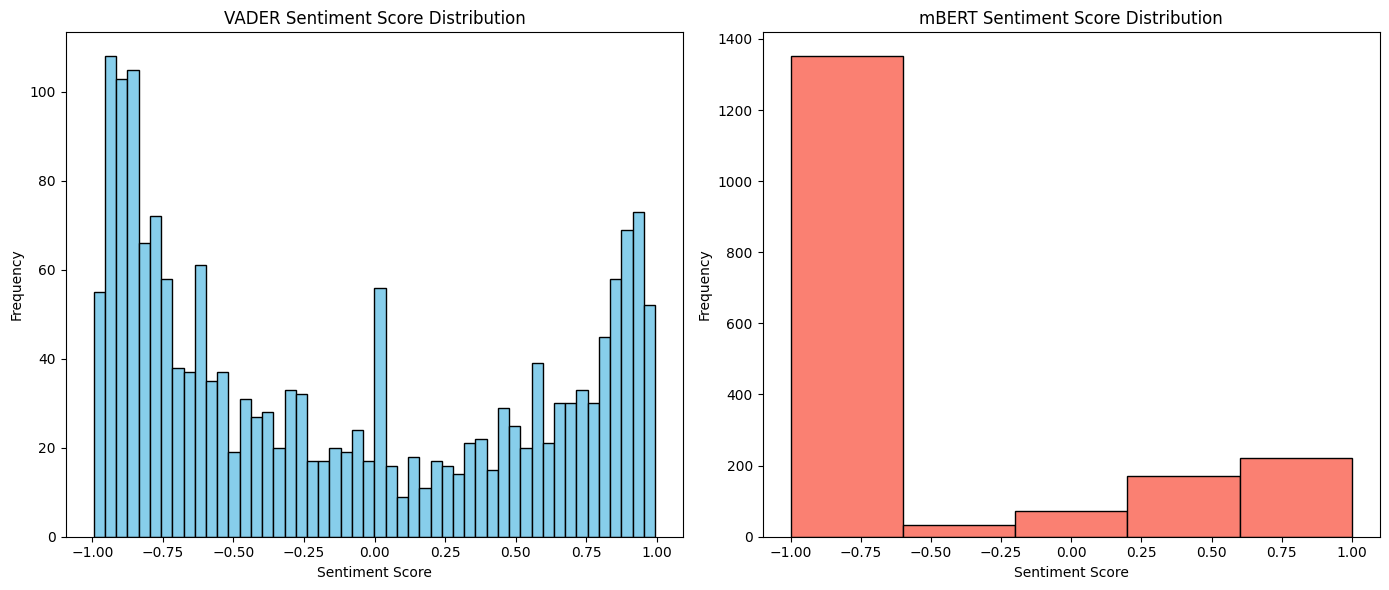

In [31]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(14, 6))

# VADER Sentiment Score Histogram
plt.subplot(1, 2, 1)
plt.hist(df['sentiment_score'], bins=50, color='skyblue', edgecolor='black')
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# mBERT Sentiment Score Histogram
plt.subplot(1, 2, 2)
plt.hist(df['sentiment_score_mbert'], bins=5, color='salmon', edgecolor='black')  # Bins correspond to possible scores
plt.title('mBERT Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

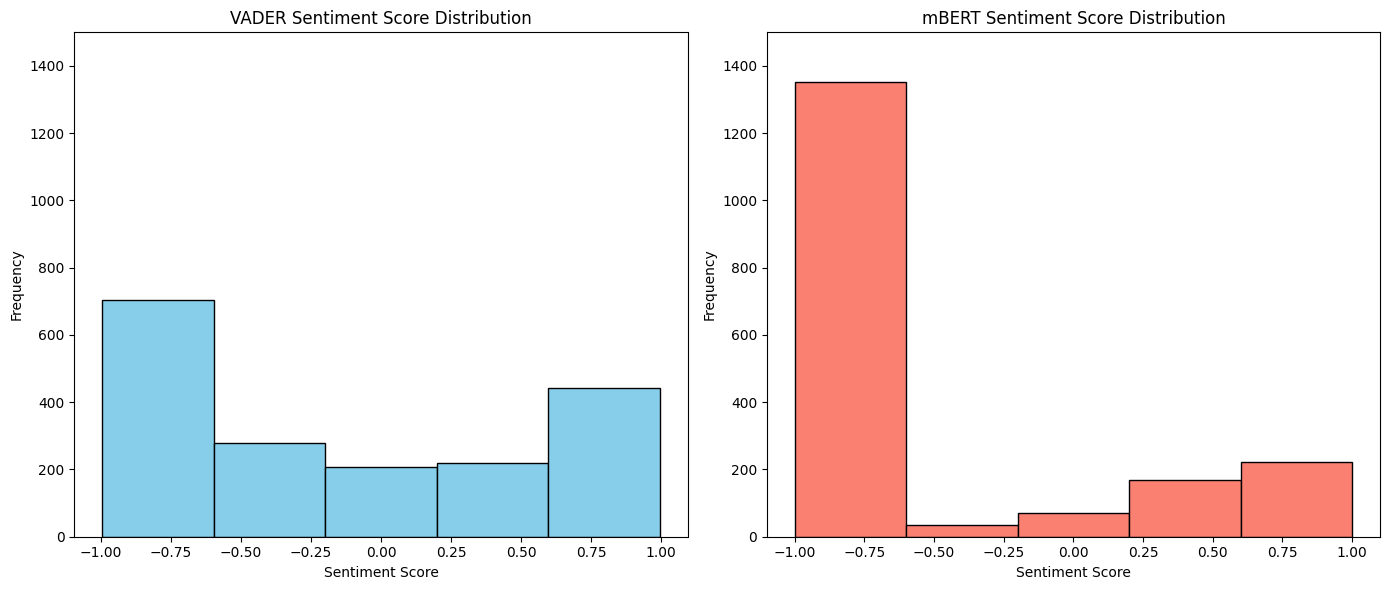

In [32]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(14, 6))

# VADER Sentiment Score Histogram
plt.subplot(1, 2, 1)
plt.hist(df['sentiment_score'], bins=5, color='skyblue', edgecolor='black')
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.ylim(0, 1500)  # Set y-axis limit

# mBERT Sentiment Score Histogram
plt.subplot(1, 2, 2)
plt.hist(df['sentiment_score_mbert'], bins=5, color='salmon', edgecolor='black')
plt.title('mBERT Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.ylim(0, 1500)  # Set y-axis limit

plt.tight_layout()
plt.show()


/tmp/ipykernel_120134/1710329387.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment_score'], shade=True, color='blue')
/tmp/ipykernel_120134/1710329387.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment_score_mbert'], shade=True, color='red')


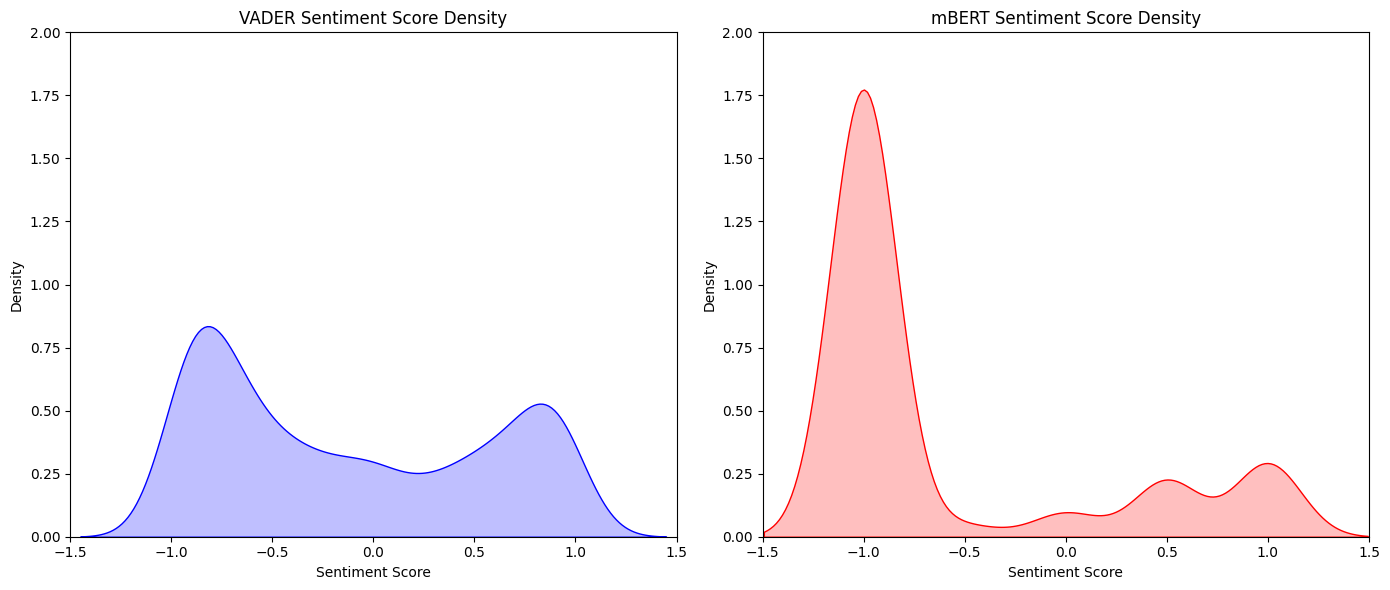

In [27]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Definir el rango común del eje x y del eje y
x_range = (-1.5, 1.5)
y_range = (0, 2)

# VADER Sentiment Score Density Plot
plt.subplot(1, 2, 1)
sns.kdeplot(df['sentiment_score'], shade=True, color='blue')
plt.title('VADER Sentiment Score Density')
plt.xlabel('Sentiment Score')
plt.xlim(x_range)
plt.ylim(y_range)

# mBERT Sentiment Score Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(df['sentiment_score_mbert'], shade=True, color='red')
plt.title('mBERT Sentiment Score Density')
plt.xlabel('Sentiment Score')
plt.xlim(x_range)
plt.ylim(y_range)

plt.tight_layout()
plt.show()


In [7]:
correlation = df[['sentiment_score', 'sentiment_score_mbert']].corr(method='pearson')
print("Correlation between VADER and mBERT sentiment scores:")
print(correlation)

Correlation between VADER and mBERT sentiment scores:
                       sentiment_score  sentiment_score_mbert
sentiment_score               1.000000               0.673894
sentiment_score_mbert         0.673894               1.000000


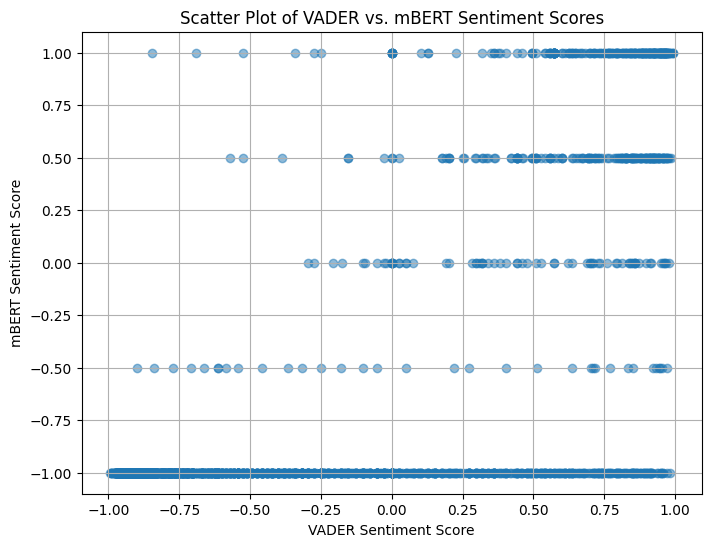

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment_score'], df['sentiment_score_mbert'], alpha=0.5)
plt.title('Scatter Plot of VADER vs. mBERT Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('mBERT Sentiment Score')
plt.grid(True)
plt.show()

In [9]:
def classify_mbert_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_mbert'] = df['sentiment_score_mbert'].apply(classify_mbert_sentiment)


from sklearn.metrics import confusion_matrix, classification_report

# Create the confusion matrix
conf_matrix = confusion_matrix(df['sentiment'], df['sentiment_mbert'], labels=['Positive', 'Neutral', 'Negative'])

# Display the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Positive', 'Neutral', 'Negative'], columns=['Positive', 'Neutral', 'Negative'])
print("Confusion Matrix:")
print(conf_matrix_df)

# Classification report
print("\nClassification Report:")
print(classification_report(df['sentiment'], df['sentiment_mbert'], labels=['Positive', 'Neutral', 'Negative']))

Confusion Matrix:
          Positive  Neutral  Negative
Positive       368       55       290
Neutral         12       10        52
Negative        11        7      1043

Classification Report:
              precision    recall  f1-score   support

    Positive       0.94      0.52      0.67       713
     Neutral       0.14      0.14      0.14        74
    Negative       0.75      0.98      0.85      1061

    accuracy                           0.77      1848
   macro avg       0.61      0.54      0.55      1848
weighted avg       0.80      0.77      0.75      1848



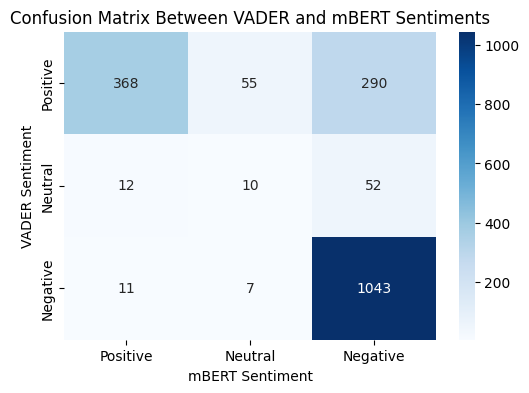

In [10]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix Between VADER and mBERT Sentiments')
plt.ylabel('VADER Sentiment')
plt.xlabel('mBERT Sentiment')
plt.show()

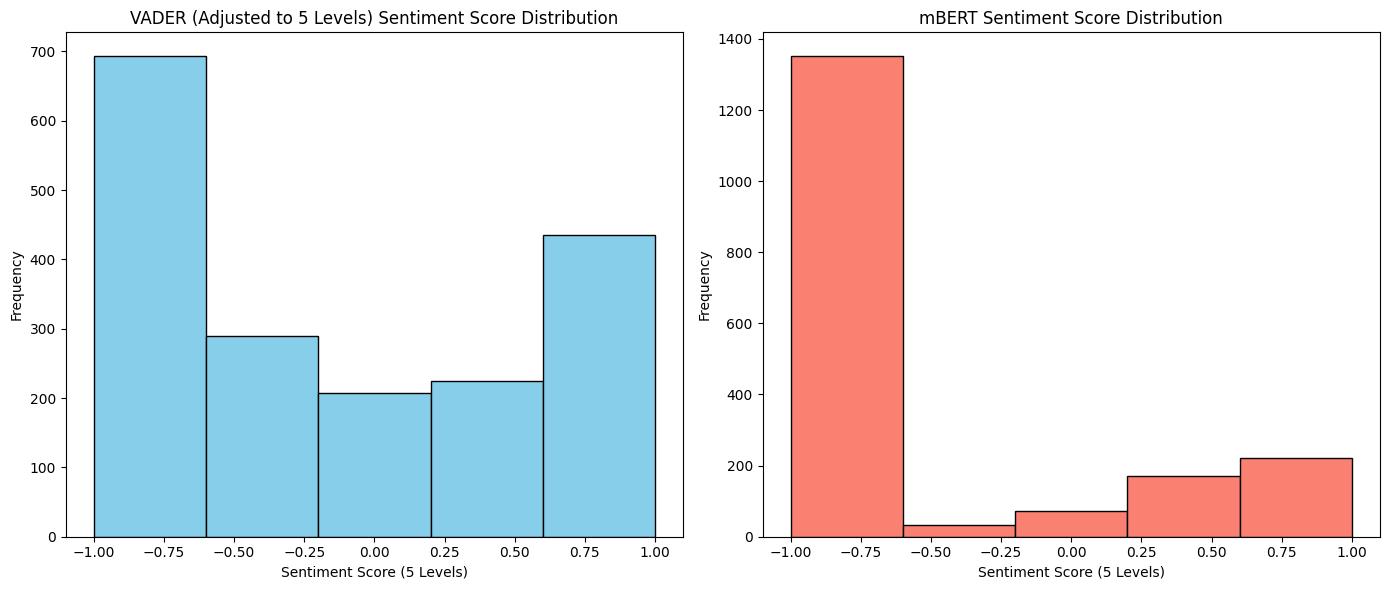

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df['sentiment_score']` and `df['sentiment_score_mbert']` already exist

# Define a function to categorize VADER sentiment scores into 5 bins
def categorize_vader_score(score):
    if score <= -0.6:
        return -1.0  # 1 star equivalent
    elif score <= -0.2:
        return -0.5  # 2 stars equivalent
    elif score <= 0.2:
        return 0.0   # 3 stars equivalent
    elif score <= 0.6:
        return 0.5   # 4 stars equivalent
    else:
        return 1.0   # 5 stars equivalent

# Apply the categorization function to create comparable VADER scores
df['vader_score_5bins'] = df['sentiment_score'].apply(categorize_vader_score)

# Plotting the histograms for VADER (5 bins) and mBERT
plt.figure(figsize=(14, 6))

# Adjusted VADER Sentiment Score Histogram
plt.subplot(1, 2, 1)
plt.hist(df['vader_score_5bins'], bins=5, color='skyblue', edgecolor='black')
plt.title('VADER (Adjusted to 5 Levels) Sentiment Score Distribution')
plt.xlabel('Sentiment Score (5 Levels)')
plt.ylabel('Frequency')

# mBERT Sentiment Score Histogram
plt.subplot(1, 2, 2)
plt.hist(df['sentiment_score_mbert'], bins=5, color='salmon', edgecolor='black')
plt.title('mBERT Sentiment Score Distribution')
plt.xlabel('Sentiment Score (5 Levels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3 Subjectivity Analysis

- 0= objetivo
- 1= subjetivo

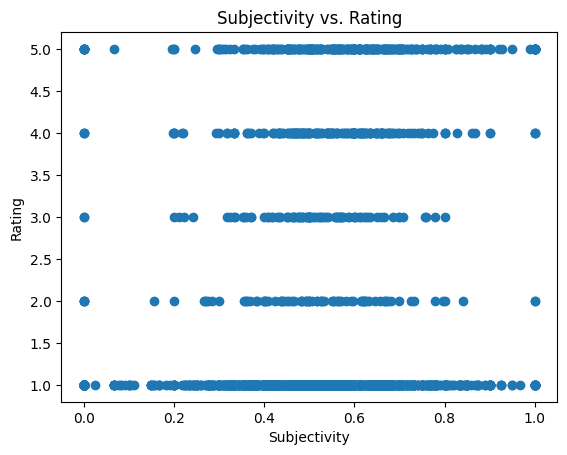

In [12]:
# Import TextBlob
from textblob import TextBlob

# Define a function to get subjectivity scores
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to the dataset
df['subjectivity'] = df['review'].apply(get_subjectivity)

# Analyze the relationship between subjectivity and rating
import matplotlib.pyplot as plt

plt.scatter(df['subjectivity'], df['rating'])
plt.xlabel('Subjectivity')
plt.ylabel('Rating')
plt.title('Subjectivity vs. Rating')
plt.show()


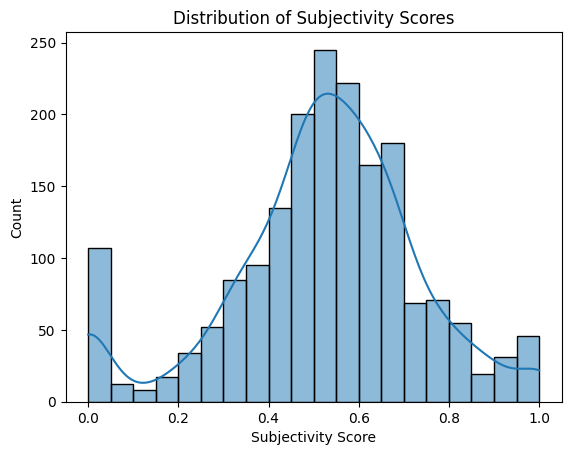

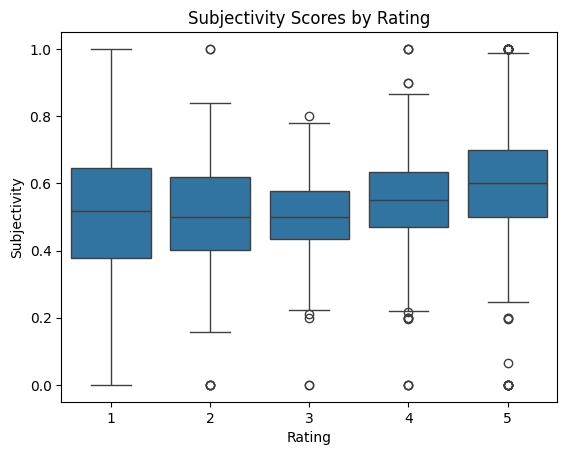

In [37]:
import seaborn as sns

# Plot the distribution of subjectivity scores
sns.histplot(df['subjectivity'], bins=20, kde=True)
plt.xlabel('Subjectivity Score')
plt.title('Distribution of Subjectivity Scores')
plt.show()

# Boxplot of subjectivity scores by rating
sns.boxplot(x='rating', y='subjectivity', data=df)
plt.xlabel('Rating')
plt.ylabel('Subjectivity')
plt.title('Subjectivity Scores by Rating')
plt.show()


   source_language  subjectivity
0               cy      0.000000
1               de      0.534203
2               en      0.528366
3               es      0.518852
4               fr      0.564502
5               id      0.000000
6               it      0.360203
7               lt      0.000000
8               lv      0.000000
9               nl      0.331288
10              pt      0.594864
11              so      0.000000


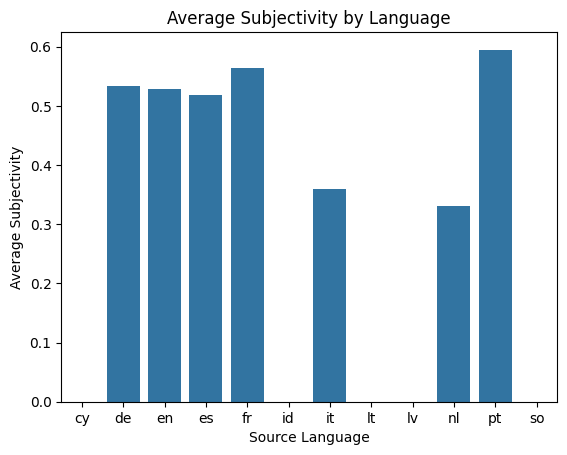

In [15]:

language_subjectivity = df.groupby('source_language')['subjectivity'].mean().reset_index()
print(language_subjectivity)

# Visualize
sns.barplot(x='source_language', y='subjectivity', data=language_subjectivity)
plt.xlabel('Source Language')
plt.ylabel('Average Subjectivity')
plt.title('Average Subjectivity by Language')
plt.show()


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


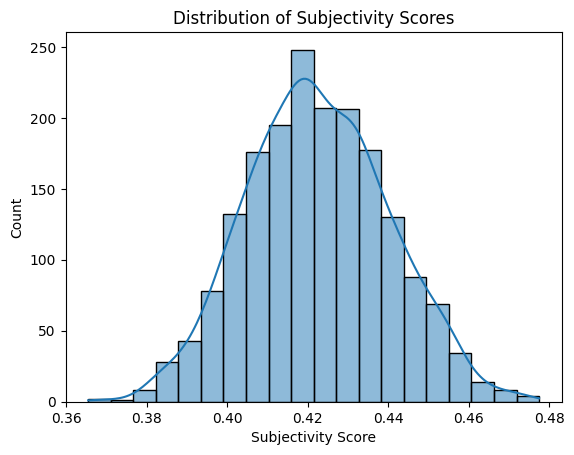

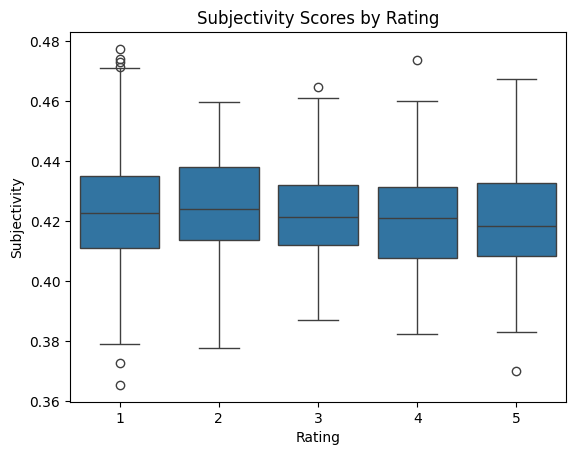

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline

# Configuración del modelo y tokenizador
model_name = "bert-base-uncased"  # Cambia según el modelo adecuado para subjetividad
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Crear el pipeline de análisis de subjetividad
subjectivity_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Función para obtener el puntaje de subjetividad
def get_subjectivity(text):
    result = subjectivity_analyzer(text, truncation=True)[0]
    label = result['label']
    score = result['score']

    # Asignar un valor de subjetividad según la clasificación
    return score if label == 'LABEL_1' else 1 - score  # `LABEL_1` representa subjetivo

# Aplicar la función a la columna 'review' para obtener subjetividad
df['subjectivity'] = df['review'].apply(get_subjectivity)

# Gráfico de distribución de puntajes de subjetividad
sns.histplot(df['subjectivity'], bins=20, kde=True)
plt.xlabel('Subjectivity Score')
plt.title('Distribution of Subjectivity Scores')
plt.show()

# Gráfico de caja de puntajes de subjetividad por calificación
sns.boxplot(x='rating', y='subjectivity', data=df)
plt.xlabel('Rating')
plt.ylabel('Subjectivity')
plt.title('Subjectivity Scores by Rating')
plt.show()


## 4 Topic Modeling with LDA


In [16]:
# Import necessary libraries
from gensim import corpora, models
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
from collections import Counter

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load English tokenizer, POS tagger, etc.
nlp = spacy.load('en_core_web_sm')

# Initial stopwords list
stop_words = set(stopwords.words('english'))

# Domain-specific stopwords
domain_stopwords = ['flight', 'airline', 'flybondi', 'plane', 'air', 'flights', 'fly', 'airlines']
stop_words.update(domain_stopwords)

# Function to preprocess text
def preprocess(text):
    # Tokenize and lemmatize
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.lemma_.isalpha()]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['review'].apply(preprocess)

# Most common tokens (to see if any should be added to stopwords)
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print(token_counts.most_common(50))


[nltk_data] Downloading package punkt to /home/joaquin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaquin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/joaquin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[('time', 917), ('travel', 746), ('day', 703), ('hour', 694), ('change', 688), ('airport', 668), ('bad', 654), ('company', 651), ('cancel', 641), ('return', 583), ('service', 565), ('take', 526), ('go', 506), ('pay', 487), ('good', 485), ('without', 471), ('delay', 455), ('first', 435), ('schedule', 433), ('leave', 410), ('trip', 398), ('experience', 390), ('give', 388), ('one', 378), ('make', 376), ('never', 374), ('buy', 368), ('another', 322), ('person', 316), ('cost', 314), ('money', 293), ('would', 292), ('tell', 292), ('arrive', 290), ('check', 265), ('get', 262), ('want', 262), ('passage', 241), ('price', 236), ('recommend', 236), ('lose', 232), ('seat', 232), ('ticket', 231), ('disaster', 224), ('low', 223), ('charge', 223), ('problem', 220), ('luggage', 219), ('say', 215), ('everything', 212)]


In [17]:
good_threshold = 4
bad_threshold = 2
good_reviews = df[df['rating'] >= good_threshold].copy()
bad_reviews = df[df['rating'] <= bad_threshold].copy()


In [18]:
def perform_lda(dataframe, num_topics=3):
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(dataframe['tokens'])
    corpus = [dictionary.doc2bow(text) for text in dataframe['tokens']]

    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        workers=2,
        random_state=42
    )

    # Print the topics
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx+1}: {topic}\n")

    return lda_model, corpus, dictionary


In [19]:
print("Topics in Bad Reviews:")
bad_lda_model, bad_corpus, bad_dictionary = perform_lda(bad_reviews)


Topics in Bad Reviews:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Topic 1: 0.026*"change" + 0.017*"time" + 0.014*"airport" + 0.013*"day" + 0.012*"hour" + 0.011*"travel" + 0.011*"schedule" + 0.010*"go" + 0.010*"company" + 0.008*"buy"

Topic 2: 0.019*"cancel" + 0.014*"return" + 0.014*"bad" + 0.013*"day" + 0.012*"travel" + 0.012*"hour" + 0.011*"company" + 0.011*"without" + 0.010*"take" + 0.009*"time"

Topic 3: 0.017*"time" + 0.013*"bad" + 0.012*"day" + 0.011*"hour" + 0.009*"take" + 0.009*"company" + 0.008*"pay" + 0.007*"give" + 0.007*"service" + 0.007*"cancel"



Interpretación de 5 topics:
- Topic 1; Schedule changes and delays affectinc travel plans
- Topic 2: Poor customer service and unexpected charges
- Topic 3: Flight cancellation and time wasted
- Topic 4: Delays and financial loss
- Topic 5: Payment issues and no reimbursments

Interpretación de 3 topics:
- Topic 1 : Schedule Changes and Delays
- Topic 2 : Poor Service, Cancellations, and Extra Charges
- Topic 3 : Flight Cancellations and Time Lost 

In [20]:
print("Topics in Good Reviews:")
good_lda_model, good_corpus, good_dictionary = perform_lda(good_reviews)


Topics in Good Reviews:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Topic 1: 0.023*"excellent" + 0.016*"time" + 0.015*"service" + 0.014*"good" + 0.014*"travel" + 0.011*"trip" + 0.010*"well" + 0.010*"price" + 0.009*"staff" + 0.008*"thank"

Topic 2: 0.028*"good" + 0.014*"time" + 0.013*"cost" + 0.011*"price" + 0.011*"airport" + 0.011*"service" + 0.011*"low" + 0.010*"palomar" + 0.010*"company" + 0.010*"first"

Topic 3: 0.028*"good" + 0.017*"time" + 0.016*"travel" + 0.014*"experience" + 0.013*"first" + 0.012*"excellent" + 0.012*"airport" + 0.010*"everything" + 0.009*"schedule" + 0.009*"friendly"



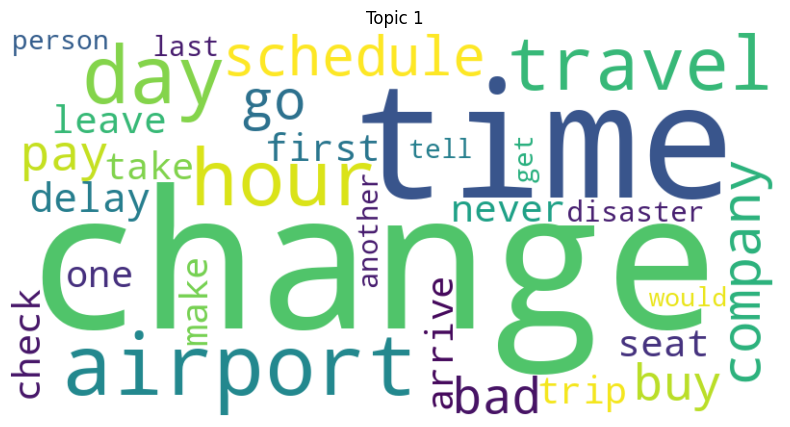

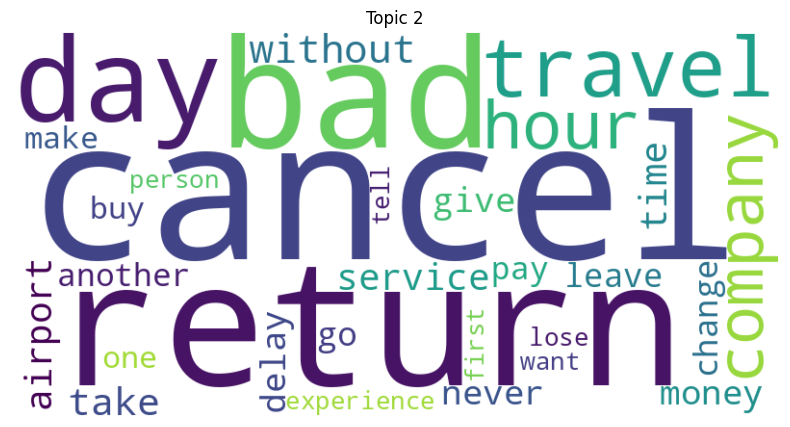

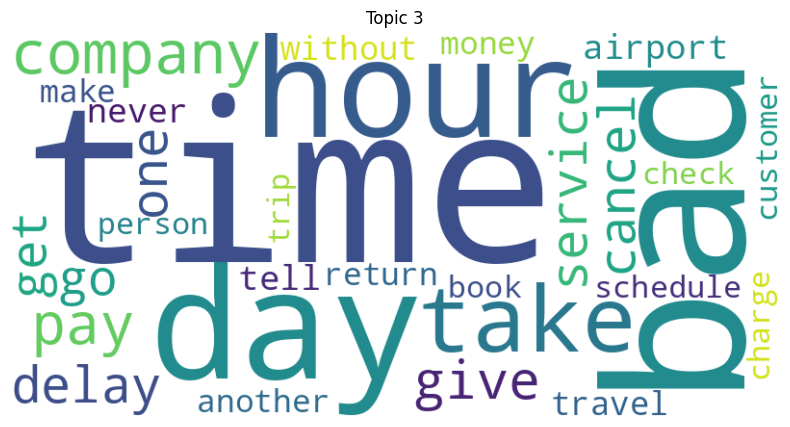

In [21]:
from wordcloud import WordCloud

def plot_word_cloud(lda_model, dictionary, topic_num):
    words = dict(lda_model.show_topic(topic_num, 30))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_num+1}")
    plt.show()

# Plot word clouds for topics in bad reviews
for topic_num in range(bad_lda_model.num_topics):
    plot_word_cloud(bad_lda_model, bad_dictionary, topic_num)


# Second Version

[nltk_data] Downloading package punkt to /home/joaquin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaquin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Topic 0: 0.019*"cancel" + 0.018*"day" + 0.015*"time" + 0.014*"bad" + 0.014*"hour" + 0.014*"change" + 0.013*"company" + 0.012*"return" + 0.011*"travel" + 0.010*"airport"

Topic 1: 0.015*"pay" + 0.014*"luggage" + 0.012*"check" + 0.012*"hour" + 0.010*"time" + 0.010*"airport" + 0.009*"go" + 0.009*"delay" + 0.008*"seat" + 0.008*"charge"

Topic 2: 0.025*"good" + 0.017*"travel" + 0.016*"time" + 0.013*"service" + 0.013*"first" + 0.013*"excellent" + 0.012*"schedule" + 0.011*"price" + 0.010*"trip" + 0.008*"attention"

Topic 3: 0.013*"airport" + 0.013*"time" + 0.008*"never" + 0.007*"buenos" + 0.007*"arrive" + 0.007*"go" + 0.007*"aire" + 0.006*"company" + 0.006*"hour" + 0.005*"person"

Topic 4: 0.013*"change" + 0.010*"pay" + 0.009*"passage" + 0.009*"delay" + 0.008*"return" + 0.008*"travel" + 0.008*"take" + 0.007*"airport" + 0.007*"first" + 0.007*"suitcase"



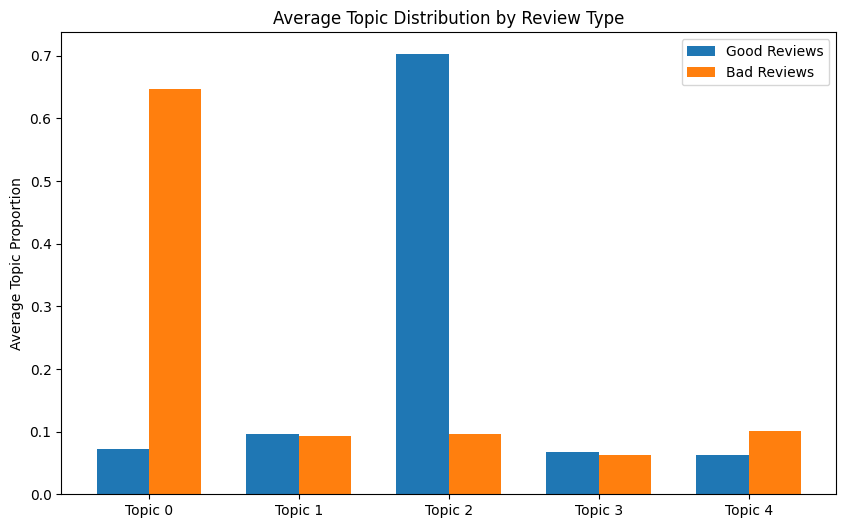

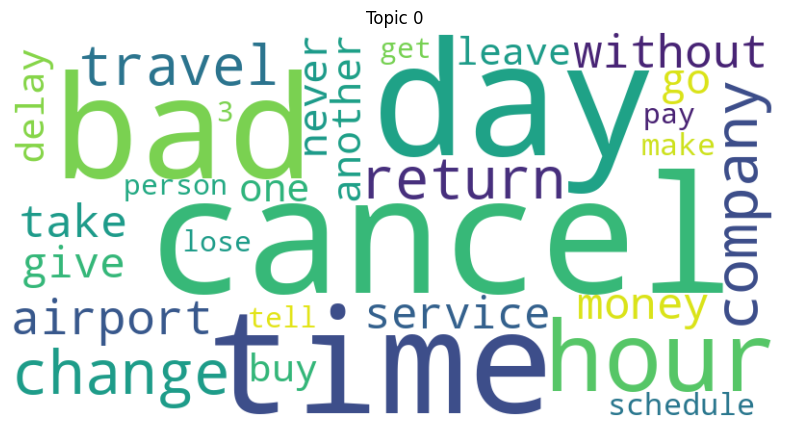

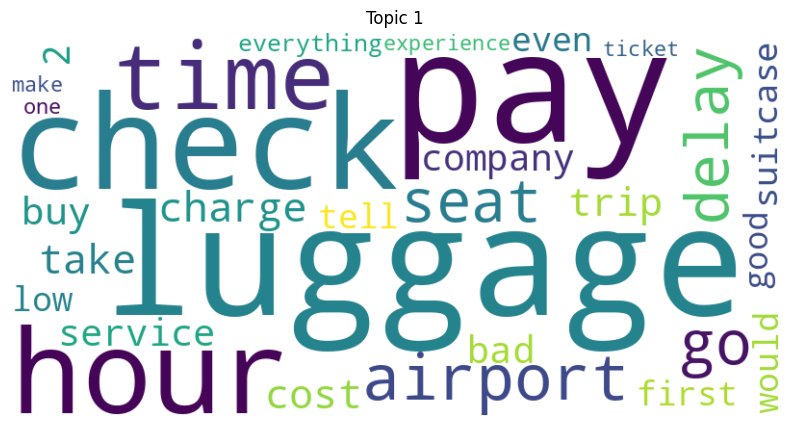

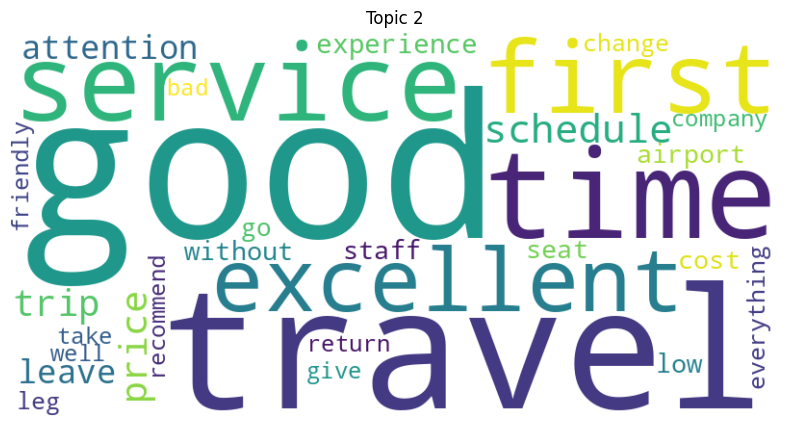

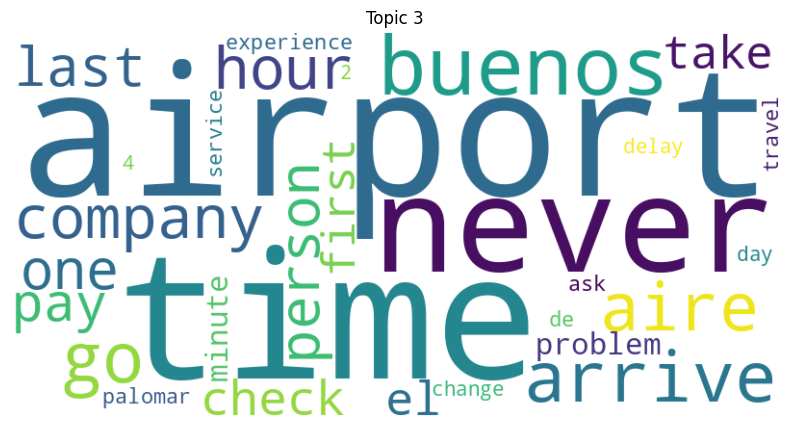

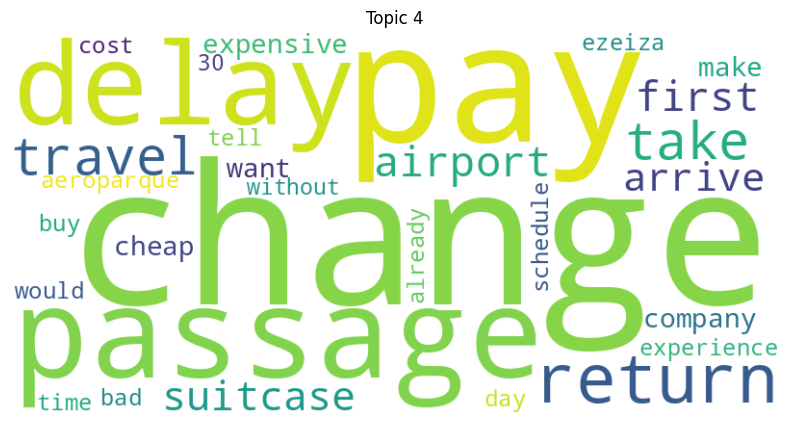

In [22]:
# Import necessary libraries
from gensim import corpora, models
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load English tokenizer, POS tagger, etc.
nlp = spacy.load('en_core_web_sm')

# Initial stopwords list
stop_words = set(stopwords.words('english'))

# Domain-specific stopwords
domain_stopwords = ['flight', 'airline', 'flybondi', 'plane', 'air', 'flights', 'fly', 'airlines']
stop_words.update(domain_stopwords)

# Function to preprocess text
def preprocess(text):
    # Tokenize and lemmatize
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Apply preprocessing to all reviews
df['tokens'] = df['review'].apply(preprocess)

# Create dictionary and corpus from all reviews
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Train LDA model on all reviews
num_topics = 5  # Adjust as needed
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,
    workers=2,
    random_state=42
)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}\n")

# Get topic distributions for each review
def get_topic_distribution(lda_model, corpus):
    return [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

df['topic_distribution'] = get_topic_distribution(lda_model, corpus)

# Label reviews
good_threshold = 4
bad_threshold = 2
df['label'] = df['rating'].apply(lambda x: 'good' if x >= good_threshold else ('bad' if x <= bad_threshold else 'neutral'))

# Separate reviews
good_reviews = df[df['label'] == 'good']
bad_reviews = df[df['label'] == 'bad']

# Calculate average topic distributions
def average_topic_distribution(reviews):
    distributions = []
    for dist in reviews['topic_distribution']:
        dist_dict = {topic_id: prob for topic_id, prob in dist}
        distributions.append(dist_dict)
    df_distributions = pd.DataFrame(distributions).fillna(0)
    return df_distributions.mean()

good_topic_avg = average_topic_distribution(good_reviews)
bad_topic_avg = average_topic_distribution(bad_reviews)

# Plot average topic distributions
topics = [f'Topic {i}' for i in range(num_topics)]
x = np.arange(len(topics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, good_topic_avg, width, label='Good Reviews')
rects2 = ax.bar(x + width/2, bad_topic_avg, width, label='Bad Reviews')

ax.set_ylabel('Average Topic Proportion')
ax.set_title('Average Topic Distribution by Review Type')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

plt.show()

# Plot word clouds for all topics
def plot_word_cloud(lda_model, topic_num):
    words = dict(lda_model.show_topic(topic_num, 30))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_num}")
    plt.show()

for topic_num in range(num_topics):
    plot_word_cloud(lda_model, topic_num)

## 5 Aspect-Based Sentiment analysis

- provee información sobre areas específicas de mejora
- ayuda a priorizar acciones basadas en aspectos que se consideraron negativos

service   -0.091385
price      0.320349
comfort    0.310409
staff      0.222747
food       0.002660
flight    -0.198478
delay     -0.358200
dtype: float64


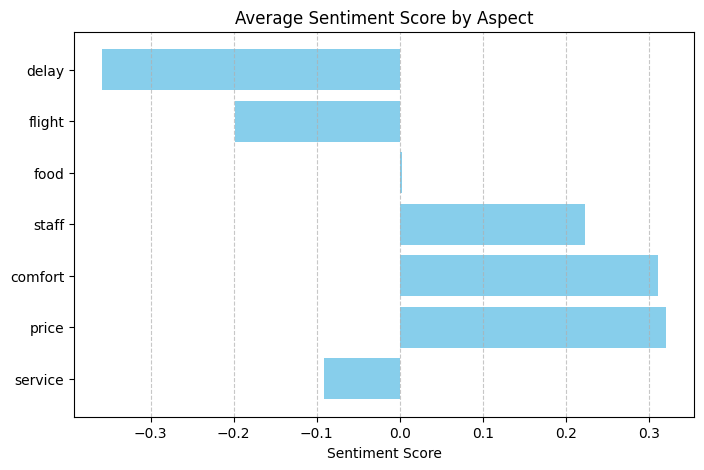

In [23]:
import numpy as np
aspects = ['service', 'price', 'comfort', 'staff', 'food', 'flight', 'delay']

def aspect_sentiment(review):
    sentences = nltk.sent_tokenize(review)
    aspect_sentiments = {}
    for aspect in aspects:
        aspect_sentiments[aspect] = []
        for sentence in sentences:
            if aspect in sentence.lower():
                score = sid.polarity_scores(sentence)['compound']
                aspect_sentiments[aspect].append(score)
    # Average sentiment per aspect
    for aspect in aspect_sentiments:
        if aspect_sentiments[aspect]:
            aspect_sentiments[aspect] = np.mean(aspect_sentiments[aspect])
        else:
            aspect_sentiments[aspect] = None
    return aspect_sentiments

df['aspect_sentiments'] = df['review'].apply(aspect_sentiment)

aspect_df = df['aspect_sentiments'].apply(pd.Series)

aspect_summary = aspect_df.mean()
print(aspect_summary)


plt.figure(figsize=(8, 5))
plt.barh(aspect_summary.index, aspect_summary.values, color='skyblue')
plt.xlabel('Sentiment Score')
plt.title('Average Sentiment Score by Aspect')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()


## 6 Flight Experience Stages
- Se puede sacar el relevance_score si se quiere uno promediado de manera uniforme
- ayuda a encontrar areas de mejora particulares a un proceso de vuelo

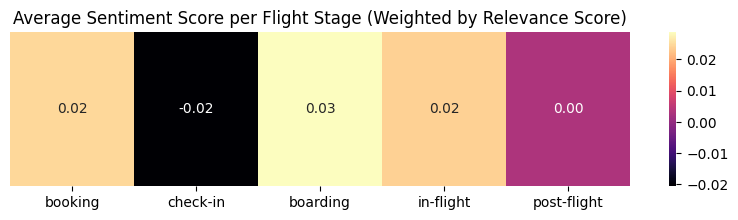

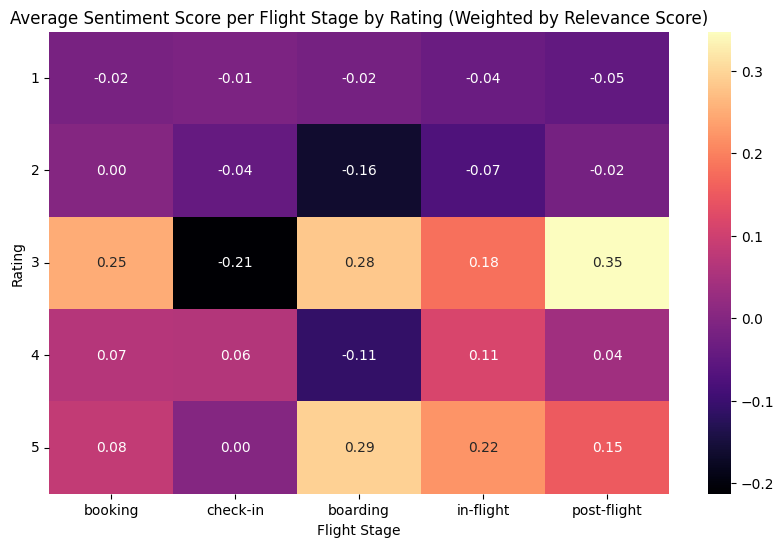

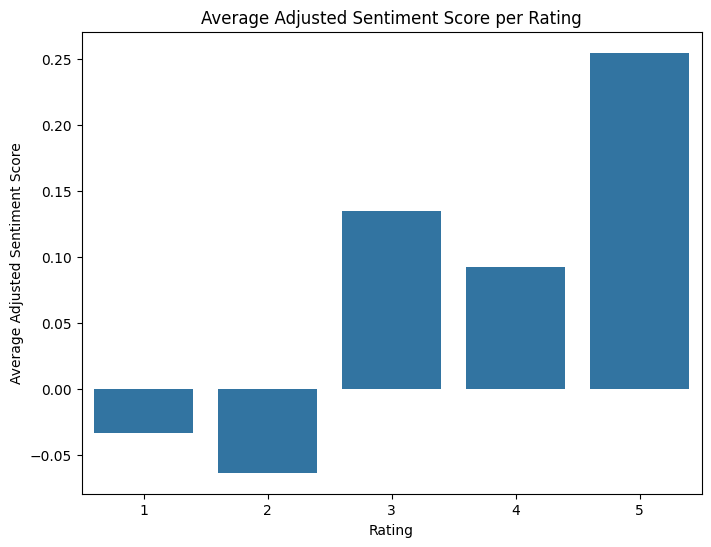

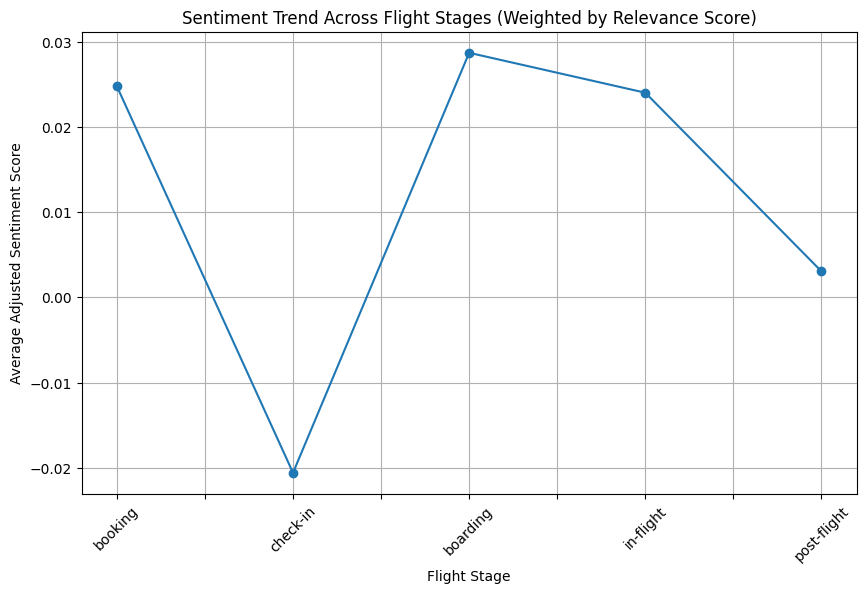

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Palabras asociadas a flight stages
flight_stages_keywords = {
    'booking': ['booking', 'reservation', 'ticket purchase', 'purchase', 'buying tickets', 'online booking'],
    'check-in': ['check-in', 'checkin', 'check in', 'baggage drop', 'luggage drop', 'counter', 'kiosk', 'online check-in'],
    'boarding': ['boarding', 'gate', 'queue', 'line', 'boarding process', 'security', 'passport control'],
    'in-flight': ['in-flight', 'flight', 'onboard', 'cabin', 'crew', 'seat', 'seating', 'entertainment', 'food', 'beverage', 'service', 'comfort', 'turbulence'],
    'post-flight': ['post-flight', 'arrival', 'baggage claim', 'lost luggage', 'customer service', 'complaint', 'feedback', 'delay', 'connections', 'transit']
}

# Como el valor de relevance es muy chico entonces lo scaleamos un poco
df['scaled_relevance'] = df['relevance_score'] * 10

def get_stage_sentiments_weighted(row):
    review = row['review']
    sentiment_score = row['sentiment_score']
    scaled_relevance = row['scaled_relevance']
    stage_sentiments = {stage: [] for stage in flight_stages_keywords.keys()}
    review_lower = review.lower()
    # por cada review se busca si hay alguna palabra clave en cada etapa
    for stage, keywords in flight_stages_keywords.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', review_lower):
                # si se encuentra la palabra clave se ajusta el score
                adjusted_score = sentiment_score * scaled_relevance # si no queremos que se ajuste en base a relavance sacamos el scaled_relevance
                stage_sentiments[stage].append(adjusted_score)

    # se hace una pasada por cada etapa para calcular el promedio de los scores ( sum(score * relevance) / sum(relevance) )
    for stage in stage_sentiments:
        if stage_sentiments[stage]:
            stage_sentiments[stage] = np.mean(stage_sentiments[stage])
        else:
            stage_sentiments[stage] = np.nan
    return pd.Series(stage_sentiments)

df_stage_sentiments = df.apply(get_stage_sentiments_weighted, axis=1)

# --- Graph 1: Combined Heatmap ---

# Calculate average sentiment score for each stage
stage_avg_sentiments = df_stage_sentiments.mean()

# Plot combined heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(stage_avg_sentiments.values.reshape(1, -1), annot=True, fmt=".2f", cmap='magma', xticklabels=stage_avg_sentiments.index)
plt.title('Average Sentiment Score per Flight Stage (Weighted by Relevance Score)')
plt.yticks([])
plt.show()

# --- Graph 2: Heatmap by Rating ---

# Combine stage sentiments with ratings
df_stage_ratings = pd.concat([df[['rating']], df_stage_sentiments], axis=1)

# Group by rating and calculate mean sentiment scores for each stage
stage_rating_avg_sentiments = df_stage_ratings.groupby('rating').mean()

# Order the ratings from 1 to 5
stage_rating_avg_sentiments = stage_rating_avg_sentiments.sort_index(ascending=True)

# Plot heatmap separated by rating score
plt.figure(figsize=(10, 6))
sns.heatmap(stage_rating_avg_sentiments, annot=True, fmt=".2f", cmap='magma', xticklabels=stage_rating_avg_sentiments.columns, yticklabels=stage_rating_avg_sentiments.index)
plt.title('Average Sentiment Score per Flight Stage by Rating (Weighted by Relevance Score)')
plt.xlabel('Flight Stage')
plt.ylabel('Rating')
plt.yticks(rotation=0)
plt.show()

# --- Graph 3: Bar Plot of Average Adjusted Sentiment Score per Rating ---

# Calculate adjusted sentiment score for each review
df['adjusted_sentiment'] = df['sentiment_score'] * df['scaled_relevance']

# Group by rating and calculate mean adjusted sentiment
rating_avg_sentiment = df.groupby('rating')['adjusted_sentiment'].mean().reset_index()

# Order the ratings from 1 to 5
rating_avg_sentiment = rating_avg_sentiment.sort_values('rating')

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='rating', y='adjusted_sentiment', data=rating_avg_sentiment, order=rating_avg_sentiment['rating'])
plt.title('Average Adjusted Sentiment Score per Rating')
plt.xlabel('Rating')
plt.ylabel('Average Adjusted Sentiment Score')
plt.xticks(rotation=0)
plt.show()

# --- Graph 4: Line Plot of Sentiment Trend Across Flight Stages ---

# Plot line chart
plt.figure(figsize=(10, 6))
stage_avg_sentiments.plot(kind='line', marker='o')
plt.title('Sentiment Trend Across Flight Stages (Weighted by Relevance Score)')
plt.xlabel('Flight Stage')
plt.ylabel('Average Adjusted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 7 Net Promoter Score (Based on Vader)


In [25]:
# Define NPS categories based on sentiment score
def predict_nps(score):
    if score >= 0.05:
        return 'Promoter'
    elif score <= -0.05:
        return 'Detractor'
    else:
        return 'Passive'

# Apply the function to your dataframe
df['nps_category'] = df['sentiment_score'].apply(predict_nps)

# Check the distribution of NPS categories
print(df['nps_category'].value_counts())


nps_category
Detractor    1061
Promoter      713
Passive        74
Name: count, dtype: int64


## 8 Review summary

Join reviews and ask for a summary